In [ ]:
%matplotlib inline

In [3]:
import os
os.getcwd()
#os.chdir("../")

'/home/anne/Dropbox/RECHERCHE/CODE/MLExtreme'

In [5]:
# # Tutorial notebook for classification on extreme covariates

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import MLExtreme as mlx

Norm function: L2 norm. change `ord` to 1 or inf for variants 

In [6]:
def norm_func(x):
    return np.linalg.norm(x, ord=2, axis=1)

## 1. Example with two classes from noisy dirichlet mixture angular distribution


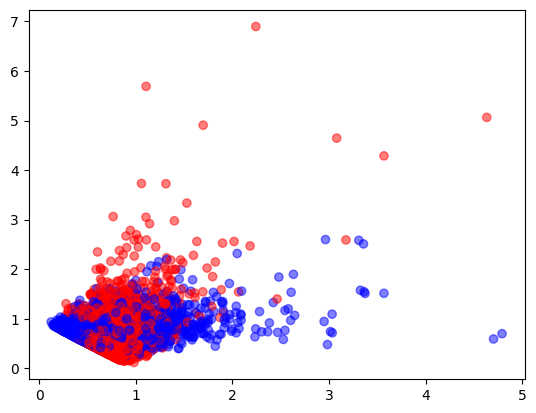

In [7]:
# data generation
n = 10000
np.random.seed(2)
X, y = mlx.gen_classif_data_diriClasses(mu0 = np.array([0.7, 0.3]),
                                        lnu=np.log(10)*np.ones(2),
                                        index_weight_noise=1, size=n)
# Visualization of the generated data
colors = np.where( y  == 1, 'red', 'blue').flatten()
plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.5)
plt.show()

Accuracy: 0.6867
0-1 loss: 0.3133


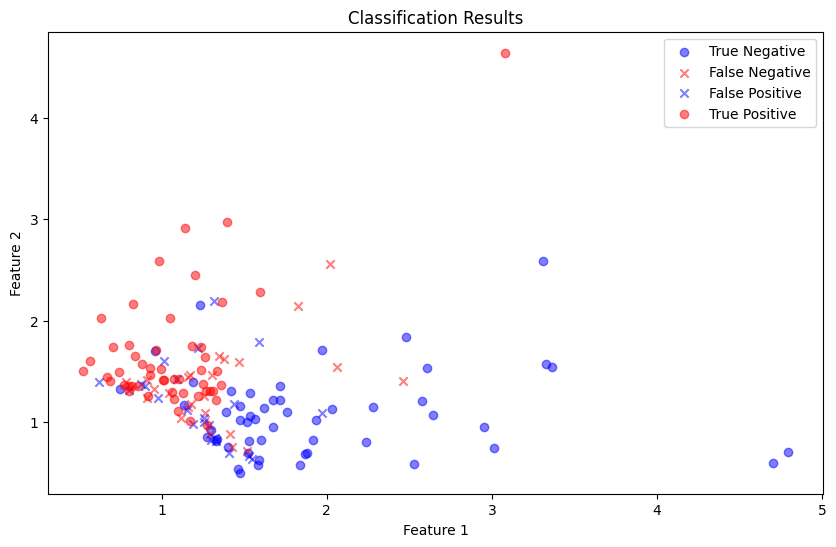

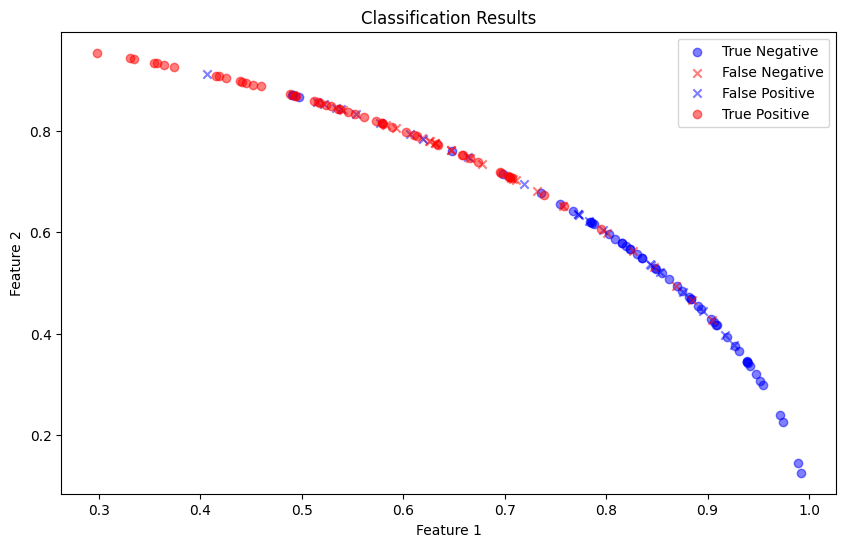

In [8]:
# choice of a classification algorithm
model = RandomForestClassifier()
# Classifier class initialization
classifier = mlx.Classifier(model, norm_func)

# Threshold choices
# (to choose training threshold, cross-validation is done in Section 3 below)
ratio_ext_pred = 0.05  # prediction threshold: upper quantile order
ratio_ext_train=0.2    # training threshold: upper quantile order
radii = norm_func(X)
thresh_predict = np.quantile(radii, 1-ratio_ext_pred)
k_train = int(n * ratio_ext_train)


# Splitting the data into training and test sets
split = 0.3
X_train, X_test, y_train, y_test = train_test_split(X,  y,
                                                    test_size=split,
                                                    random_state=42)

# Model training
threshold, ratio, X_train_extreme = classifier.fit(X_train, y_train, k=500)

# Prediction on the test data
y_pred_extreme,  X_test_extreme, mask_test = classifier.predict(
                                            X_test, thresh_predict)

# Accuracy evaluation
y_test_extreme = y_test[mask_test]
accuracy = accuracy_score(y_test_extreme, y_pred_extreme)
print(f'Accuracy: {accuracy:.4f}')
hamming = hamming_loss(y_test_extreme, y_pred_extreme)
print(f'0-1 loss: {hamming:.4f}')

# Display classification results

classifier.plot_classif(X_test_extreme, y_test_extreme, y_pred_extreme)
X_test_extrem_unit = X_test_extreme / norm_func(X_test_extreme)[:, np.newaxis]
classifier.plot_classif(X_test_extrem_unit, y_test_extreme, y_pred_extreme)

## 2. Same example with non standard input
(coordinates of X may have different regular variation indices,
or even not be regularly varying at all)

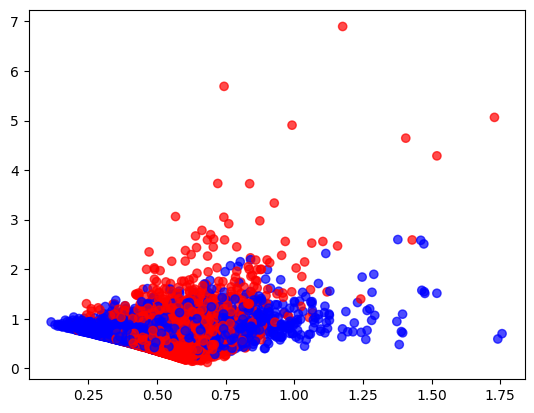

In [9]:
# transform one component of X: X_raw is not jointly regularly varying.
X_raw = np.copy(X)
X_raw[:, 0] = np.log(1 + X[:, 0])
colors = np.where( y  == 1, 'red', 'blue')
plt.figure()
plt.scatter(X_raw[:, 0], X_raw[:, 1], c=colors, alpha=0.7)
plt.show()

Accuracy: 0.6831
0-1 loss: 0.3169


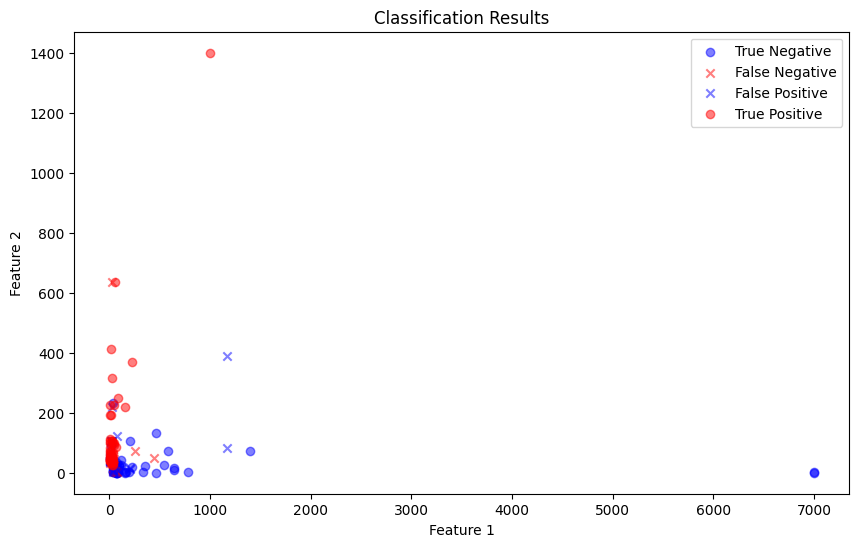

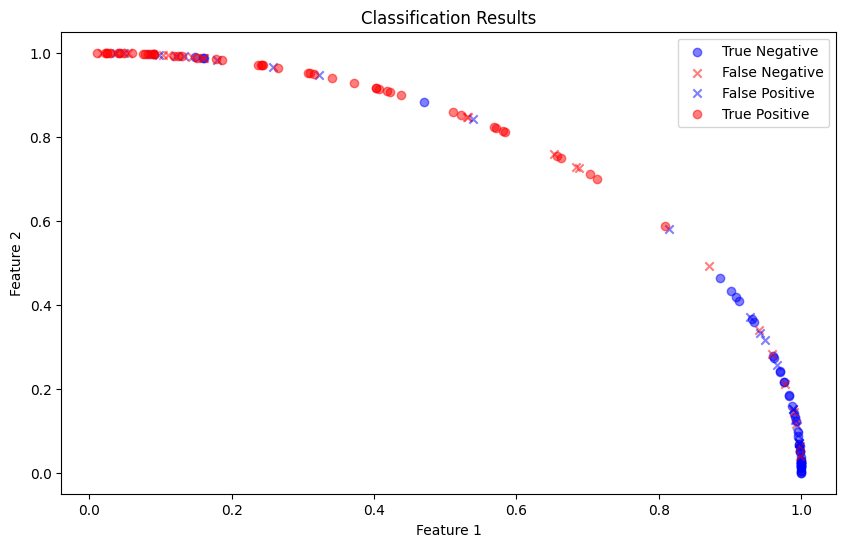

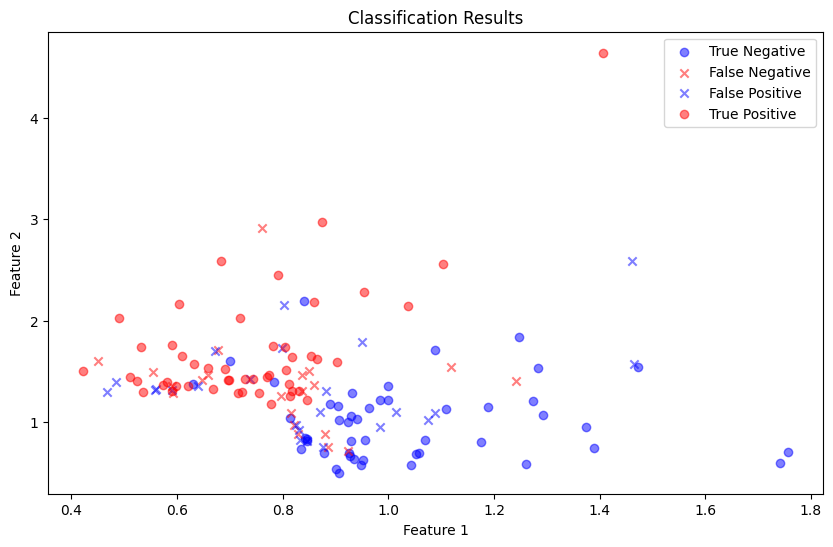

In [10]:
# choice of a classification algorithm
model = RandomForestClassifier()
# Classifier class initialization
classifier = mlx.Classifier(model, norm_func)

# set thresh_predict relative to rank-standardized  data
std_X = mlx.rank_transform(X_raw)
ratio_ext_pred = 0.05  # prediction threshold: upper quantile order
ratio_ext_train=0.2    # training threshold: upper quantile order
radii = norm_func(std_X)
thresh_predict = np.quantile(radii, 1-ratio_ext_pred)
k_train = int(n * ratio_ext_train)


# Splitting the data into training and test sets
split = 0.3
X_train, X_test, y_train, y_test = train_test_split(X_raw,  y,
                                                    test_size=split,
                                                    random_state=42)

# transform the training input into unit Pareto margins
std_X_train = mlx.rank_transform(X_train)
# learn the rank transformation on X_train and apply it to X_test
std_X_test = mlx.rank_transform_test(x_train=X_train, x_test=X_test)


# Model training on standardized data
threshold, ratio, _ = classifier.fit(std_X_train, y_train, k=500)

# Prediction on the standardized test data
y_pred_extreme,  std_X_test_extreme, mask_test = classifier.predict(
                                            std_X_test, thresh_predict)

# Accuracy evaluation
y_test_extreme = y_test[mask_test]
accuracy = accuracy_score(y_test_extreme, y_pred_extreme)
print(f'Accuracy: {accuracy:.4f}')
hamming = hamming_loss(y_test_extreme, y_pred_extreme)
print(f'0-1 loss: {hamming:.4f}')
# performance similar to case 1. Rank-transformation does not significantly
# alter the results. 


# Display classification results  in the pareto (rank-transformed) scale
classifier.plot_classif(std_X_test_extreme, y_test_extreme, y_pred_extreme)
X_test_extrem_unit = std_X_test_extreme / \
                    norm_func(std_X_test_extreme)[:, np.newaxis]
classifier.plot_classif(X_test_extrem_unit, y_test_extreme, y_pred_extreme)


# Display classification results  in the original scale
classifier.plot_classif(X_test[mask_test], y_test_extreme, y_pred_extreme)

## 3. Cross-validation 
for:
   - Evaluating model performance on extremes and choosing one  
   - choosing k (at training step)
following Aghbalou et al's CV scheme (K-fold)

### 3.a Goal: choosing a classification model

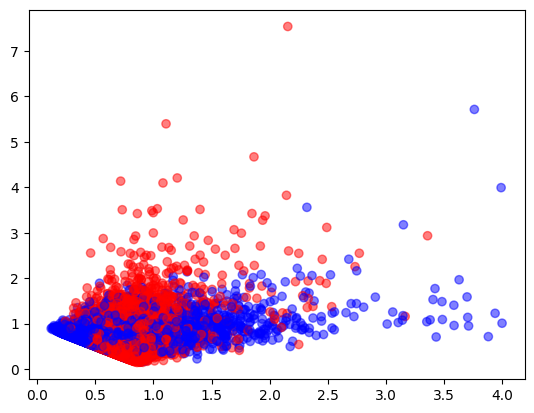

In [11]:
# Generate data
n=20000
np.random.seed(1)
X, y = mlx.gen_classif_data_diriClasses(mu0 = np.array([0.7, 0.3]),
                                               lnu=np.log(10)*np.ones(2),
                                               index_weight_noise=1, size=n)
# Visualization of the generated data
colors = np.where( y  == 1, 'red', 'blue').flatten()
plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.5)
plt.show()

hamming_loss1 (std): 0.326998474446987  (0.06294082556527363)
hamming_loss2 (std): 0.17119755911517925  (0.02080775639882662)


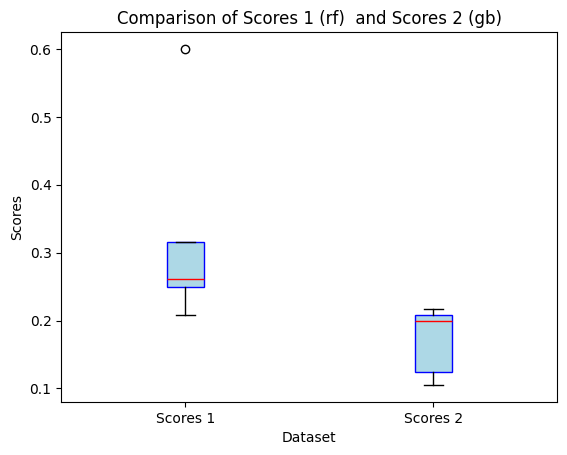

In [12]:
# choice of  2 classification algorithm
model1 = RandomForestClassifier()
model2 = GradientBoostingClassifier()

# Classifier class initialization
classifier1 = mlx.Classifier(model1, norm_func)
classifier2 = mlx.Classifier(model2, norm_func)

# threshold setting: prediction threshold larger than training threshold
Norm_X = norm_func(X)
n = len(Norm_X)
ratio_train = 0.1
ratio_test = 0.005
k_train = int(n * ratio_train)
thresh_predict = np.quantile(Norm_X, 1 - ratio_test)

#  Perform cross-validation (may be time consuming) for fixed k_train
#  to compare the two models 
mean_scores1, sd_mean_scores1, scores1 = classifier1.cross_validate(
    X, y, k=k_train, thresh_predict=thresh_predict, random_state=42)

mean_scores2, sd_mean_scores2, scores2 = classifier2.cross_validate(
    X, y, k=k_train, thresh_predict=thresh_predict, random_state=42)

print(f"hamming_loss1 (std): {mean_scores1}  ({sd_mean_scores1})")
print(f"hamming_loss2 (std): {mean_scores2}  ({sd_mean_scores2})")

plt.boxplot([scores1, scores2], tick_labels=['Scores 1', 'Scores 2'],
            patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red'))
plt.xlabel('Dataset')
plt.ylabel('Scores')
plt.title('Comparison of Scores 1 (rf)  and Scores 2 (gb)')
plt.show()
# gb seems to perform better .on this example

### 3.b goal:  choosing the training threshold.
        (designed for a fixed prediction threshold)

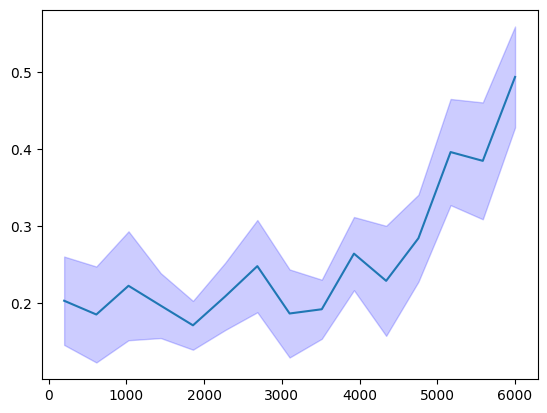

Optimal k: 1857
 optimal training ratio: 0.09285


In [14]:
# in view of 3.a, we choose model2 (gb). 
classifier = mlx.Classifier(model2, norm_func)

# choose a range of training k's and reset the prediction threshold
n = len(Norm_X)
ratio_train = np.linspace(0.01, 0.3, num=15)
ratio_test = 0.005
k_train = (n * ratio_train).astype(int)
thresh_predict = np.quantile(Norm_X, 1-ratio_test)

# compute cv scores for each value of k_train
kscores = []
kscores_sd = []
# !time consuming
for k in k_train:
    mean_scores, sd_mean_scores, _ = classifier.cross_validate(
        X, y, k=k, thresh_predict=thresh_predict,
        scoring=hamming_loss,
        random_state=42 + 103*k)
    kscores.append(mean_scores)
    kscores_sd.append(sd_mean_scores)

kscores = np.array(kscores)
kscores_sd = np.array(kscores_sd)
plt.plot(k_train, kscores)
plt.fill_between(k_train, kscores + 1.64 * kscores_sd,
                 kscores - 1.64 * kscores_sd, color='blue', alpha=0.2)
plt.show()

i_opt = np.argmin(kscores)
k_opt = k_train[i_opt]
print(f'Optimal k: {k_opt}')
ratio_opt = k_opt/n
print(f' optimal training ratio: {ratio_opt}')
# choice of k around k=2000  looks optimal with gb
# for predicting above thresh_predict fixed above.
